# PySpark PyTorch Inference

### Image Classification
Based on: https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html  

Also demonstrates accelerated inference on GPU with Torch-TensorRT. 

In [1]:
import torch

from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
torch.__version__

'2.4.1+cu121'

In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [4]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [5]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28]) torch.float32
Shape of y: torch.Size([64]) torch.int64


### Create model

In [6]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cuda device
NeuralNetwork(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


### Train Model

In [7]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [8]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        X = torch.flatten(X, start_dim=1, end_dim=-1)

        # Zero gradients
        optimizer.zero_grad()

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [9]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            X = torch.flatten(X, start_dim=1, end_dim=-1)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [10]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.301038  [   64/60000]
loss: 2.289769  [ 6464/60000]
loss: 2.268618  [12864/60000]
loss: 2.264085  [19264/60000]
loss: 2.244277  [25664/60000]
loss: 2.209504  [32064/60000]
loss: 2.220515  [38464/60000]
loss: 2.185288  [44864/60000]
loss: 2.186121  [51264/60000]
loss: 2.149065  [57664/60000]
Test Error: 
 Accuracy: 37.8%, Avg loss: 2.151644 

Epoch 2
-------------------------------
loss: 2.164946  [   64/60000]
loss: 2.157853  [ 6464/60000]
loss: 2.100765  [12864/60000]
loss: 2.117897  [19264/60000]
loss: 2.058581  [25664/60000]
loss: 1.995217  [32064/60000]
loss: 2.026708  [38464/60000]
loss: 1.948186  [44864/60000]
loss: 1.959582  [51264/60000]
loss: 1.881658  [57664/60000]
Test Error: 
 Accuracy: 52.5%, Avg loss: 1.886264 

Epoch 3
-------------------------------
loss: 1.922469  [   64/60000]
loss: 1.893279  [ 6464/60000]
loss: 1.780482  [12864/60000]
loss: 1.822908  [19264/60000]
loss: 1.696129  [25664/60000]
loss: 1.653140  [32064/600

### Save Model State Dict
This saves the serialized object to disk using pickle.

In [11]:
torch.save(model.state_dict(), "model.pt")
print("Saved PyTorch Model State to model.pt")

Saved PyTorch Model State to model.pt


### Save Model as TorchScript
This saves an [intermediate representation of the compute graph](https://pytorch.org/tutorials/beginner/saving_loading_models.html#export-load-model-in-torchscript-format), which does not require pickle (or even python). 

In [12]:
scripted = torch.jit.script(model)
scripted.save("ts_model.pt")
print("Saved TorchScript Model to ts_model.pt")

Saved TorchScript Model to ts_model.pt


### Load Model State

In [13]:
model_from_state = NeuralNetwork().to(device)
model_from_state.load_state_dict(torch.load("model.pt", weights_only=True))

<All keys matched successfully>

In [14]:
model_from_state.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    x = torch.flatten(x.to(device), start_dim=1, end_dim=-1)
    pred = model_from_state(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Load Torchscript Model

In [15]:
# Load model to original device (GPU) and move to CPU. 
ts_model = torch.jit.load("ts_model.pt")

In [16]:
x, y = test_data[0][0], test_data[0][1]

In [17]:
with torch.no_grad():
    pred = ts_model(torch.flatten(x.to(device), start_dim=1, end_dim=-1))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Ankle boot", Actual: "Ankle boot"


### Compile using the Torch JIT Compiler
This leverages the [Torch-TensorRT inference compiler](https://pytorch.org/TensorRT/) for accelerated inference on GPUs using the `torch.compile` JIT interface under the hood. The compiler stack returns a [boxed-function](http://blog.ezyang.com/2020/09/lets-talk-about-the-pytorch-dispatcher/) that triggers compilation on the first call.  

Modules compiled in this fashion are [not serializable with pickle](https://github.com/pytorch/pytorch/issues/101107#issuecomment-1542688089), so we cannot send the compiled model directly to Spark. Instead, we will recompile and cache the model on the executor. 

(You may see a warning about modelopt quantization. This is safe to ignore, as [implicit quantization](https://docs.nvidia.com/deeplearning/tensorrt/developer-guide/index.html#intro-quantization) is deprecated in the latest TensorRT. See [this link](https://pytorch.org/TensorRT/tutorials/_rendered_examples/dynamo/vgg16_fp8_ptq.html) for a guide to explicit quantization.)

In [24]:
import torch_tensorrt as trt
import time

In [19]:
# Optional: set the filename for the TensorRT timing cache
timestamp = time.time()
timing_cache = f"/tmp/timing_cache-{timestamp}.bin"
with open(timing_cache, "wb") as f:
    pass

In [20]:
inputs_bs1 = torch.randn((1, 784), dtype=torch.float).to("cuda")
# This indicates dimension 0 of inputs_bs1 is dynamic whose range of values is [1, 50]. No recompilation will happen when the batch size changes.
torch._dynamo.mark_dynamic(inputs_bs1, 0, min=1, max=64)
trt_model = trt.compile(
    model,
    ir="torch_compile",
    inputs=inputs_bs1,
    enabled_precisions={torch.float},
    timing_cache_path=timing_cache,
)

stream = torch.cuda.Stream()
with torch.no_grad(), torch.cuda.stream(stream):
    pred = trt_model(torch.flatten(x.to(device), start_dim=1, end_dim=-1))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

INFO:torch_tensorrt.dynamo.utils:Using Default Torch-TRT Runtime (as requested by user)
INFO:torch_tensorrt.dynamo.utils:Device not specified, using Torch default current device - cuda:0. If this is incorrect, please specify an input device, via the device keyword.
INFO:torch_tensorrt.dynamo.utils:Compilation Settings: CompilationSettings(enabled_precisions={<dtype.f32: 7>}, debug=False, workspace_size=0, min_block_size=5, torch_executed_ops=set(), pass_through_build_failures=False, max_aux_streams=None, version_compatible=False, optimization_level=None, use_python_runtime=False, truncate_double=False, use_fast_partitioner=True, enable_experimental_decompositions=False, device=Device(type=DeviceType.GPU, gpu_id=0), require_full_compilation=False, disable_tf32=False, assume_dynamic_shape_support=False, sparse_weights=False, refit=False, engine_capability=<EngineCapability.STANDARD: 1>, num_avg_timing_iters=1, dla_sram_size=1048576, dla_local_dram_size=1073741824, dla_global_dram_size=53

Predicted: "Ankle boot", Actual: "Ankle boot"


### Compile using the Torch-TensorRT AOT Compiler
Alternatively, use the Torch-TensorRT Dynamo backend for Ahead-of-Time (AOT) compilation to eagerly optimize the model in an explicit compilation phase. We first export the model to produce a traced graph representing the Tensor computation in an AOT fashion, which produces a `ExportedProgram` object which can be [serialized and reloaded](https://pytorch.org/TensorRT/user_guide/saving_models.html). We can then compile this IR using the Torch-TensorRT AOT compiler for inference.   

[Read the docs](https://pytorch.org/TensorRT/user_guide/torch_tensorrt_explained.html) for more information on JIT vs AOT compilation.

In [21]:
# Preparing the inputs for batch_size = 1. 
inputs = (torch.randn((1, 784), dtype=torch.float).cuda(),)

# Produce traced graph in the ExportedProgram format
exp_program = trt.dynamo.trace(model_from_state, inputs)
# Compile the traced graph to produce an optimized module
trt_gm = trt.dynamo.compile(exp_program, 
                            inputs=inputs, 
                            timing_cache_path=timing_cache)

stream = torch.cuda.Stream()
with torch.no_grad(), torch.cuda.stream(stream):
    trt_gm(torch.flatten(x.to(device), start_dim=1, end_dim=-1))
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

INFO:torch_tensorrt.dynamo._compiler:Compilation Settings: CompilationSettings(enabled_precisions={<dtype.f32: 7>}, debug=False, workspace_size=0, min_block_size=5, torch_executed_ops=set(), pass_through_build_failures=False, max_aux_streams=None, version_compatible=False, optimization_level=None, use_python_runtime=False, truncate_double=False, use_fast_partitioner=True, enable_experimental_decompositions=False, device=Device(type=DeviceType.GPU, gpu_id=0), require_full_compilation=True, disable_tf32=False, assume_dynamic_shape_support=False, sparse_weights=False, refit=False, engine_capability=<EngineCapability.STANDARD: 1>, num_avg_timing_iters=1, dla_sram_size=1048576, dla_local_dram_size=1073741824, dla_global_dram_size=536870912, dryrun=False, hardware_compatible=False, timing_cache_path='/tmp/timing_cache-1729187850.4862776.bin')

INFO:torch_tensorrt.dynamo._compiler:Partitioning the graph via the fast partitioner
INFO:torch_tensorrt [TensorRT Conversion Context]:[MemUsageChange

Predicted: "Ankle boot", Actual: "Ankle boot"


We can save the compiled model using `torch_tensorrt.save`. Unfortunately, serializing the model to be reloaded at a later date currently only supports *static inputs*.

In [23]:
with torch.cuda.stream(stream):
    trt.save(trt_gm, "trt_model_aot.ep", inputs=[torch.randn((1, 784), dtype=torch.float).to("cuda")])
    print("Saved AOT compiled TensorRT model to trt_model_aot.ep")

Saved AOT compiled TensorRT model to trt_model_aot.ep


## PySpark

### Convert numpy dataset to Pandas DataFrame

In [21]:
import pandas as pd
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, ArrayType, FloatType

In [22]:
data = test_data.data.numpy()
data.shape, data.dtype

((10000, 28, 28), dtype('uint8'))

In [23]:
data = data.reshape(10000, 784) / 255.0
data.shape, data.dtype

((10000, 784), dtype('float64'))

In [24]:
pdf784 = pd.DataFrame(data)
pdf784

,0,1,2,3,4,5,6,7,8,9,...,774,775,776,777,778,779,780,781,782,783
0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.007843,0.011765,0.0,0.011765,0.682353,0.741176,0.262745,0.0,0.0,0.0
2,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.003922,0.000000,...,0.643137,0.227451,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.082353,...,0.003922,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.007843,0.0,0.003922,0.003922,0.0,0.000000,0.000000,...,0.278431,0.047059,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.121569,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.105882,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0


In [25]:
%%time
# 1 column of array<float>
pdf1 = pd.DataFrame()
pdf1['data'] = pdf784.values.tolist()
pdf1

CPU times: user 87.6 ms, sys: 56.2 ms, total: 144 ms
Wall time: 143 ms


,data
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,"[0.0, 0.0, 0.0, 0.00784313725490196, 0.0, 0.00..."
...,...
9995,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9996,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9997,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9998,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [26]:
import os
conda_env = os.environ.get("CONDA_PREFIX")

conf = SparkConf()
if 'spark' not in globals():
    # If Spark is not already started with Jupyter, attach to Spark Standalone
    import socket
    hostname = socket.gethostname()
    conf.setMaster(f"spark://{hostname}:7077") # assuming Master is on default port 7077
conf.set("spark.task.maxFailures", "1")
conf.set("spark.driver.memory", "8g")
conf.set("spark.executor.memory", "8g")
conf.set("spark.pyspark.python", f"{conda_env}/bin/python")
conf.set("spark.pyspark.driver.python", f"{conda_env}/bin/python")
conf.set("spark.sql.execution.pyspark.udf.simplifiedTraceback.enabled", "false")
conf.set("spark.sql.pyspark.jvmStacktrace.enabled", "true")
conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
conf.set("spark.python.worker.reuse", "true")
# Create Spark Session
spark = SparkSession.builder.appName("spark-dl-examples").config(conf=conf).getOrCreate()
sc = spark.sparkContext

24/10/08 00:30:18 WARN Utils: Your hostname, cb4ae00-lcedt resolves to a loopback address: 127.0.1.1; using 10.110.47.100 instead (on interface eno1)
24/10/08 00:30:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/08 00:30:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


#### Create Spark DataFrame from Pandas DataFrame

In [27]:
%%time
# force FloatType since Spark defaults to DoubleType
schema = StructType([StructField("data",ArrayType(FloatType()), True)])
df = spark.createDataFrame(pdf1, schema).repartition(8)

  if is_categorical_dtype(series.dtype):



CPU times: user 389 ms, sys: 63.2 ms, total: 452 ms
Wall time: 1.44 s


In [28]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [29]:
%%time
# force FloatType since Spark defaults to DoubleType
schema = StructType([StructField(str(x), FloatType(), True) for x in range(784)])
df784 = spark.createDataFrame(pdf784, schema).repartition(8)

CPU times: user 61 ms, sys: 21.6 ms, total: 82.6 ms
Wall time: 854 ms


### Save the test dataset as parquet files

In [30]:
%%time
df.write.mode("overwrite").parquet("fashion_mnist_1")

24/10/08 00:30:21 WARN TaskSetManager: Stage 0 contains a task of very large size (4032 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 2.09 ms, sys: 2.57 ms, total: 4.66 ms
Wall time: 1.78 s


In [31]:
%%time
df784.write.mode("overwrite").parquet("fashion_mnist_784")

24/10/08 00:30:23 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
24/10/08 00:30:23 WARN TaskSetManager: Stage 3 contains a task of very large size (7849 KiB). The maximum recommended task size is 1000 KiB.


CPU times: user 3.01 ms, sys: 22 μs, total: 3.03 ms
Wall time: 734 ms


### Check arrow memory configuration

In [ ]:
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "128")
# This line will fail if the vectorized reader runs out of memory
assert len(df.head()) > 0, "`df` should not be empty"

## Inference using Spark DL API

### 1 columns of 784 float

In [33]:
import os
import numpy as np

from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [34]:
df = spark.read.parquet("fashion_mnist_1")
len(df.columns)

1

In [35]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [36]:
# Get absolute path to model
model_path = "{}/model.pt".format(os.getcwd())

For inference on Spark, we'll compile the model with the Torch-TensorRT AOT compiler and cache on the executor. We can specify dynamic batch sizes before compilation to [optimize across multiple input shapes](https://pytorch.org/TensorRT/user_guide/dynamic_shapes.html).

In [37]:
def predict_batch_fn():
    import torch
    import torch_tensorrt as trt
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    if device != "cuda":
        raise ValueError("This function uses the TensorRT model which requires a GPU device")

    # Define model
    class NeuralNetwork(nn.Module):
        def __init__(self):
            super(NeuralNetwork, self).__init__()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(28*28, 512),
                nn.ReLU(),
                nn.Linear(512, 512),
                nn.ReLU(),
                nn.Linear(512, 10)
            )

        def forward(self, x):
            logits = self.linear_relu_stack(x)
            return logits

    model = NeuralNetwork().to(device)
    model.load_state_dict(torch.load(model_path, weights_only=True))

    # Preparing the inputs for dynamic batch sizing.
    inputs = [trt.Input(min_shape=(1, 784), 
                   opt_shape=(50, 784), 
                   max_shape=(64, 784), 
                   dtype=torch.float32)]

    # Trace the computation graph and compile to produce an optimized module
    trt_gm = trt.compile(model, ir="dynamo", inputs=inputs, require_full_compilation=True)

    def predict(inputs: np.ndarray):
        print("Predicting on process PID: {}".format(os.getpid()))
        stream = torch.cuda.Stream()
        with torch.no_grad(), torch.cuda.stream(stream):
            # use array to combine columns into tensors
            torch_inputs = torch.from_numpy(inputs).to(device)
            outputs = trt_gm(torch_inputs)
            return outputs.detach().cpu().numpy()
    
    return predict

In [38]:
mnist = predict_batch_udf(predict_batch_fn,
                          input_tensor_shapes=[[784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=50)

In [40]:
%%time
# first pass caches model/fn
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 189 ms, sys: 53.6 ms, total: 242 ms
Wall time: 9.73 s


In [41]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 195 ms, sys: 75 ms, total: 270 ms
Wall time: 1.26 s


In [42]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 199 ms, sys: 54.9 ms, total: 254 ms
Wall time: 1.27 s


### Check predictions

In [43]:
predictions = preds[0].preds
img = preds[0].data

In [44]:
import matplotlib.pyplot as plt
import numpy as np

In [45]:
img = np.array(img).reshape(28,28)

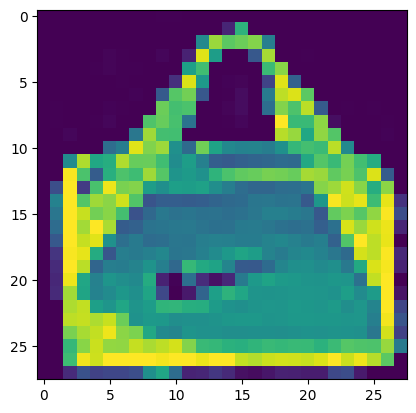

In [46]:
plt.figure()
plt.imshow(img)
plt.show()

In [47]:
print(predictions)
print("predicted label:", classes[np.argmax(predictions)])

[-1.309907078742981, -3.8460376262664795, 0.845407247543335, -2.5534284114837646, 0.7116107940673828, 0.9341840147972107, 0.4921048879623413, 0.22850888967514038, 2.951157331466675, 1.0042279958724976]
predicted label: Bag


### 784 columns of float

In [48]:
df = spark.read.parquet("fashion_mnist_784")
len(df.columns)

784

In [49]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 266 ms, sys: 69.9 ms, total: 336 ms
Wall time: 4.05 s


In [50]:
%%time
preds = df.withColumn("preds", mnist(array(*df.columns))).collect()

CPU times: user 271 ms, sys: 66.2 ms, total: 337 ms
Wall time: 1.96 s


### Check predictions

In [51]:
preds = df.withColumn("preds", mnist(array(*df.columns))).limit(10).toPandas()

In [52]:
sample = preds.iloc[0]
predictions = sample.preds
img = sample.drop('preds').to_numpy(dtype=float)

In [53]:
import matplotlib.pyplot as plt
import numpy as np

In [54]:
img = np.array(img).reshape(28,28)

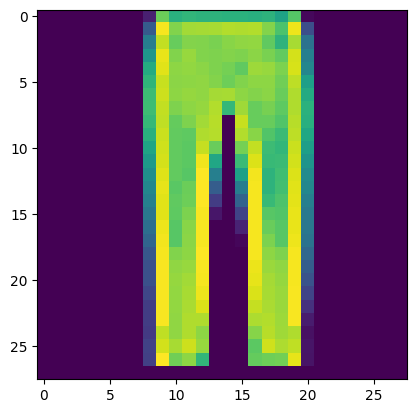

In [55]:
plt.figure()
plt.imshow(img)
plt.show()

In [56]:
print(predictions)
print("predicted label:", classes[np.argmax(predictions)])

[ 2.5953586   3.9101725   0.65233815  3.2538052   1.270339   -3.0440047
  1.1500907  -3.7935097  -1.8807431  -3.321768  ]
predicted label: Trouser


### Using Triton Inference Server

Note: you can restart the kernel and run from this point to simulate running in a different node or environment.

In [57]:
import numpy as np

from functools import partial
from pyspark.ml.functions import predict_batch_udf
from pyspark.sql.functions import struct, col, array
from pyspark.sql.types import ArrayType, FloatType, Union, Dict

In [58]:
%%bash
# copy model to expected layout for Triton
rm -rf models
mkdir -p models/fashion_mnist/1
cp ts_model.pt models/fashion_mnist/1/model.pt

# add config.pbtxt
cp models_config/fashion_mnist/config.pbtxt models/fashion_mnist/config.pbtxt

#### Start Triton Server on each executor

In [ ]:
num_executors = 1
triton_models_dir = "{}/models".format(os.getcwd())
nodeRDD = sc.parallelize(list(range(num_executors)), num_executors)

def start_triton(it):
    import docker
    import time
    import tritonclient.grpc as grpcclient
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    if containers:
        print(">>>> containers: {}".format([c.short_id for c in containers]))
    else:
        container=client.containers.run(
            "nvcr.io/nvidia/tritonserver:24.08-py3", "tritonserver --model-repository=/models",
            detach=True,
            device_requests=[docker.types.DeviceRequest(device_ids=["0"], capabilities=[['gpu']])],
            name="spark-triton",
            network_mode="host",
            remove=True,
            shm_size="64M",
            volumes={triton_models_dir: {"bind": "/models", "mode": "ro"}}
        )
        print(">>>> starting triton: {}".format(container.short_id))

        # wait for triton to be running
        time.sleep(15)
        client = grpcclient.InferenceServerClient("localhost:8001")
        ready = False
        while not ready:
            try:
                ready = client.is_server_ready()
            except Exception as e:
                time.sleep(5)
            
    return [True]

nodeRDD.barrier().mapPartitions(start_triton).collect()

#### Run inference

In [60]:
df = spark.read.parquet("fashion_mnist_1")
len(df.columns)

1

In [61]:
df.schema

StructType([StructField('data', ArrayType(FloatType(), True), True)])

In [62]:
def triton_fn(triton_uri, model_name):
    import numpy as np
    import tritonclient.grpc as grpcclient
    
    np_types = {
      "BOOL": np.dtype(np.bool_),
      "INT8": np.dtype(np.int8),
      "INT16": np.dtype(np.int16),
      "INT32": np.dtype(np.int32),
      "INT64": np.dtype(np.int64),
      "FP16": np.dtype(np.float16),
      "FP32": np.dtype(np.float32),
      "FP64": np.dtype(np.float64),
      "FP64": np.dtype(np.double),
      "BYTES": np.dtype(object)
    }

    client = grpcclient.InferenceServerClient(triton_uri)
    model_meta = client.get_model_metadata(model_name)
    
    def predict(inputs):
        if isinstance(inputs, np.ndarray):
            # single ndarray input
            request = [grpcclient.InferInput(model_meta.inputs[0].name, inputs.shape, model_meta.inputs[0].datatype)]
            request[0].set_data_from_numpy(inputs.astype(np_types[model_meta.inputs[0].datatype]))
        else:
            # dict of multiple ndarray inputs
            request = [grpcclient.InferInput(i.name, inputs[i.name].shape, i.datatype) for i in model_meta.inputs]
            for i in request:
                i.set_data_from_numpy(inputs[i.name()].astype(np_types[i.datatype()]))
        
        response = client.infer(model_name, inputs=request)
        
        if len(model_meta.outputs) > 1:
            # return dictionary of numpy arrays
            return {o.name: response.as_numpy(o.name) for o in model_meta.outputs}
        else:
            # return single numpy array
            return response.as_numpy(model_meta.outputs[0].name)
        
    return predict

In [63]:
mnist = predict_batch_udf(partial(triton_fn, triton_uri="localhost:8001", model_name="fashion_mnist"),
                          input_tensor_shapes=[[784]],
                          return_type=ArrayType(FloatType()),
                          batch_size=1024)

In [64]:
%%time
preds = df.withColumn("preds", mnist(struct(df.columns))).collect()

CPU times: user 326 ms, sys: 39.6 ms, total: 365 ms
Wall time: 1.77 s


In [65]:
%%time
preds = df.withColumn("preds", mnist(*df.columns)).collect()

CPU times: user 199 ms, sys: 63.2 ms, total: 262 ms
Wall time: 1.21 s


In [66]:
%%time
preds = df.withColumn("preds", mnist(*[col(c) for c in df.columns])).collect()

CPU times: user 195 ms, sys: 25.4 ms, total: 220 ms
Wall time: 1.21 s


Predicted label: Bag


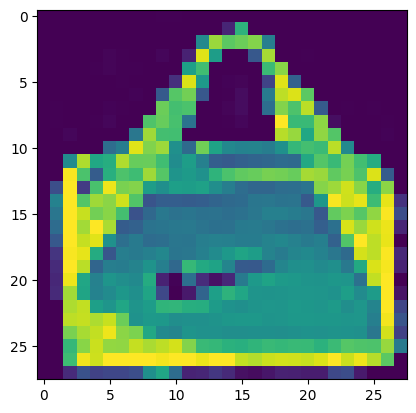

In [67]:
# Sample prediction
sample = preds[0]
predictions = sample.preds
img = sample.data

img = np.array(img).reshape(28,28)
plt.figure()
plt.imshow(img)

print("Predicted label:", classes[np.argmax(predictions)])

#### Stop Triton Server on each executor

In [ ]:
def stop_triton(it):
    import docker
    import time
    
    client=docker.from_env()
    containers=client.containers.list(filters={"name": "spark-triton"})
    print(">>>> stopping containers: {}".format([c.short_id for c in containers]))
    if containers:
        container=containers[0]
        container.stop(timeout=120)

    return [True]

nodeRDD.barrier().mapPartitions(stop_triton).collect()

In [69]:
spark.stop()